# **Cell 1** — Clean install (Colab-safe) & GPU check

In [ ]:
# !nvidia-smi -L || print("⚠️ No GPU detected. Go to Runtime > Change runtime type > GPU.")
!nvidia-smi -L
# Remove RAPIDS if present (they pin older pyarrow)
!pip -q uninstall -y cudf-cu12 dask-cudf-cu12 cuml-cu12 pylibcudf-cu12 rmm-cu12 ucx-py ucxx rapids-dask-dependency || true
# Colab-compatible versions
!pip -q install -U pandas==2.2.2 pyarrow==21.0.0
!pip -q install -U transformers datasets accelerate scikit-learn


GPU 0: Tesla T4 (UUID: GPU-240ea69e-6f91-b6a7-daf4-3ec8d00695d2)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 97.3 MB/s eta 0:00:00


# **Cell 2** — (Optional) Mount Google Drive for saving

In [ ]:
from google.colab import drive
USE_DRIVE = False   # set False if you don’t want Drive
# drive.mount('/content/drive')
if USE_DRIVE:
    SAVE_DIR = "/content/drive/MyDrive/Dataset/colab_runs"
else:
    SAVE_DIR = "/content/baitbuster_runs"

import os; os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)

Saving to: /content/baitbuster_runs


# **Cell 3** — Load dataset (CSV/Parquet/XLSX)

In [ ]:
import pandas as pd, os

CSV_PATH     = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.csv"
PARQUET_PATH = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.parquet"
XLSX_PATH    = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla_253070_18c_HL10k_AIL.xlsx"

if   os.path.exists(CSV_PATH):     df_all = pd.read_csv(CSV_PATH)
elif os.path.exists(PARQUET_PATH): df_all = pd.read_parquet(PARQUET_PATH)
elif os.path.exists(XLSX_PATH):    df_all = pd.read_excel(XLSX_PATH)
else: raise FileNotFoundError("Upload dataset and update paths above.")

print("Columns (first 30):", list(df_all.columns)[:30])
print("Rows:", len(df_all))

Columns (first 30): ['channel_id', 'channel_name', 'channel_url', 'video_id', 'publishedAt', 'title', 'title_debiased', 'description', 'description_debiased', 'url', 'viewCount', 'commentCount', 'likeCount', 'dislikeCount', 'thumbnail', 'auto_labeled', 'human_labeled', 'ai_labeled']
Rows: 253070


# **Cell 4** — Preprocess: normalize labels + pick text fields + build tabular features

In [ ]:
import numpy as np

# Choose debiased text columns if available
TITLE_COL = "title_debiased" if "title_debiased" in df_all.columns else "title"
DESC_COL  = "description_debiased" if "description_debiased" in df_all.columns else "description"

assert TITLE_COL in df_all.columns, f"Missing {TITLE_COL}"
assert DESC_COL  in df_all.columns, f"Missing {DESC_COL}"
assert "human_labeled" in df_all.columns, "Dataset lacks 'human_labeled' column."

# Normalize human labels (gold subset only)
lab = df_all["human_labeled"].astype(str).str.strip().str.lower().replace({
    "not_clickbait":"not clickbait","non-clickbait":"not clickbait","non_clickbait":"not clickbait",
    "notclickbait":"not clickbait","click bait":"clickbait","yes":"clickbait","no":"not clickbait",
    "1":"clickbait","0":"not clickbait"
})
mask = lab.isin(["clickbait","not clickbait"])

df = df_all.loc[mask].copy()

# Clean text
df[TITLE_COL] = df[TITLE_COL].astype(str).str.strip()
df[DESC_COL]  = df[DESC_COL].astype(str).str.strip()
df.loc[df[DESC_COL].eq(""), DESC_COL] = "[EMPTY]"

# Binary label
df["label"] = (lab[mask] == "clickbait").astype(int)

# Coerce engagement metrics to numeric if present
for c in ["viewCount","likeCount","commentCount","dislikeCount"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Build engineered tabular features (use only columns that exist)
def safe(col): return col if col in df.columns else None

vc, lc, cc = safe("viewCount"), safe("likeCount"), safe("commentCount")

# Positive views (avoid divide by zero)
if vc:
    df["views_pos"] = df[vc].where(df[vc] > 0)
    if lc: df["like_rate"] = df[lc] / df["views_pos"]
    if cc: df["comment_rate"] = df[cc] / df["views_pos"]

# Log transforms (helpful for heavy-tailed distributions)
for c in [vc, lc, cc]:
    if c:
        df[f"log_{c}"] = np.log1p(df[c])

# Title/desc lengths, punctuation, emojis as light features
df["title_len"] = df[TITLE_COL].str.len()
df["desc_len"]  = df[DESC_COL].str.len()
df["title_excl"] = df[TITLE_COL].str.count("!")
df["title_q"]    = df[TITLE_COL].str.count(r"\?")

# Choose a feature set that exists
tabular_cols = [c for c in [
    vc, lc, cc,
    "like_rate","comment_rate",
    f"log_{vc}" if vc else None, f"log_{lc}" if lc else None, f"log_{cc}" if cc else None,
    "title_len","desc_len","title_excl","title_q"
] if c is not None and c in df.columns]

print("Tabular features used:", tabular_cols)
print("Kept rows:", len(df))
print("Label balance 0/1:", np.bincount(df["label"]))
df[[TITLE_COL, DESC_COL, "label"] + tabular_cols].head(3)

Tabular features used: ['viewCount', 'likeCount', 'commentCount', 'like_rate', 'comment_rate', 'log_viewCount', 'log_likeCount', 'log_commentCount', 'title_len', 'desc_len', 'title_excl', 'title_q']
Kept rows: 10000
Label balance 0/1: [4356 5644]


,title_debiased,description_debiased,label,viewCount,likeCount,commentCount,like_rate,comment_rate,log_viewCount,log_likeCount,log_commentCount,title_len,desc_len,title_excl,title_q
0,এইমাত্র! মসজিদে নামাজরত অবস্থায় তিন বৃদ্ধকে পি...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1,12743,536,45,0.042062,0.003531,9.452816,6.285998,3.828641,97,412,2,0
1,"১০ বছরের সন্তান ফেলে আ,লীগ নেতার সাথে পালিয়ে গ...",ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1,22440,362,10,0.016132,0.000446,10.018645,5.894403,2.397895,90,412,1,0
2,এই মাত্র পাওয়া খবর! ৫ বছরের জেল হচ্ছে পরীমনির!...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,1,46416,677,53,0.014585,0.001142,10.745421,6.519147,3.988984,94,412,2,0


# **Cell 5** — Train/Val/Test split (60/20/20, stratified) + fit scaler on train

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib, numpy as np

# Indices for a consistent split
idx = np.arange(len(df))
train_idx, temp_idx = train_test_split(idx, test_size=0.4, stratify=df["label"].values, random_state=42)
val_idx, test_idx   = train_test_split(temp_idx, test_size=0.5, stratify=df["label"].values[temp_idx], random_state=42)

def take(ix, cols):
    return df.iloc[ix][cols].reset_index(drop=True)

# Text
tr_title, va_title, te_title = take(train_idx, [TITLE_COL])[TITLE_COL], take(val_idx, [TITLE_COL])[TITLE_COL], take(test_idx, [TITLE_COL])[TITLE_COL]
tr_desc,  va_desc,  te_desc  = take(train_idx, [DESC_COL])[DESC_COL],  take(val_idx, [DESC_COL])[DESC_COL],  take(test_idx, [DESC_COL])[DESC_COL]

# Labels
y_tr = df.iloc[train_idx]["label"].values
y_va = df.iloc[val_idx]["label"].values
y_te = df.iloc[test_idx]["label"].values

# Tabular (impute NaNs with column median on train; scale with StandardScaler)
def prepare_tab(ix):
    X = df.iloc[ix][tabular_cols].copy()
    med = X.median()
    X = X.fillna(med)
    return X, med

Xtr_tab, med = prepare_tab(train_idx)
Xva_tab = df.iloc[val_idx][tabular_cols].fillna(med)
Xte_tab = df.iloc[test_idx][tabular_cols].fillna(med)

scaler = StandardScaler().fit(Xtr_tab.values)
Xtr_tab_s = scaler.transform(Xtr_tab.values)
Xva_tab_s = scaler.transform(Xva_tab.values)
Xte_tab_s = scaler.transform(Xte_tab.values)

joblib.dump({"med": med, "scaler": scaler, "tabular_cols": tabular_cols}, os.path.join(SAVE_DIR, "tabular_scaler.joblib"))

print("Train/Val/Test sizes:", len(y_tr), len(y_va), len(y_te))
print("Train balance:", np.bincount(y_tr))
print("Val   balance:", np.bincount(y_va))
print("Test  balance:", np.bincount(y_te))

Train/Val/Test sizes: 6000 2000 2000
Train balance: [2614 3386]
Val   balance: [ 871 1129]
Test  balance: [ 871 1129]


# **Cell 6** — Build HF Datasets for dual text + tabular

In [ ]:
from datasets import Dataset
def make_ds_clean(titles, descs, tabs, labels):
    return Dataset.from_dict({
        "title": list(titles),
        "desc":  list(descs),
        "tab":   [np.asarray(row, dtype="float32") for row in tabs],
        "label": list(labels)
    })

train_ds = make_ds_clean(tr_title, tr_desc, Xtr_tab_s, y_tr)
val_ds   = make_ds_clean(va_title, va_desc, Xva_tab_s, y_va)
test_ds  = make_ds_clean(te_title, te_desc, Xte_tab_s, y_te)

len(train_ds), len(val_ds), len(test_ds)

(6000, 2000, 2000)

# **Cell 7** — Tokenize text fields (BanglaBERT tokenizer)

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "csebuetnlp/banglabert"  # or "sagorsarker/bangla-bert-base"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

MAX_T_LEN = 64
MAX_D_LEN = 128

def tok_dual_plus_tab(batch):
    t = tok(batch["title"], truncation=True, padding="max_length", max_length=MAX_T_LEN)
    d = tok(batch["desc"],  truncation=True, padding="max_length", max_length=MAX_D_LEN)
    return {
        "title_input_ids": t["input_ids"],
        "title_attention_mask": t["attention_mask"],
        "desc_input_ids": d["input_ids"],
        "desc_attention_mask": d["attention_mask"],
        "tab": batch["tab"],  # already float32 vectors
        "labels": batch["label"],
    }

train_tok = train_ds.map(tok_dual_plus_tab, batched=True, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(tok_dual_plus_tab,   batched=True, remove_columns=val_ds.column_names)
test_tok  = test_ds.map(tok_dual_plus_tab,  batched=True, remove_columns=test_ds.column_names)

train_tok.set_format(type="torch")
val_tok.set_format(type="torch")
test_tok.set_format(type="torch")

train_tok[0]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'tab': tensor([-0.0878,  0.0055, -0.0080,  0.0742, -0.2663,  0.7916,  0.9139,  0.8478,
          1.0958, -0.7309,  0.5370, -0.2902]),
 'title_input_ids': tensor([    2,   830,  1768,     1,     5,  3761, 14001,     1,  1990,  1042,
           831,  2097,  7316, 14749,  1945,   205,     1,     1,  4255,   834,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'title_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'desc_input_ids': tensor([    2, 18067, 10620,  9449,  1001,   219,  3246,  3123,  1957

# **Cell 8** — Model: Dual BanglaBERT + Tabular MLP + Fusion head

In [ ]:
import torch, torch.nn as nn
from transformers import AutoModel, AutoConfig

class DualBanglaBERTWithTab(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=2, tab_dim=None, dropout=0.3,
                 share_weights=False, freeze_lower_n_layers=0):
        super().__init__()
        cfg = AutoConfig.from_pretrained(model_name)
        self.num_labels = num_labels
        self.hidden = cfg.hidden_size

        # Encoders
        self.title_encoder = AutoModel.from_pretrained(model_name, config=cfg)
        self.desc_encoder  = self.title_encoder if share_weights else AutoModel.from_pretrained(model_name, config=cfg)

        # Tabular tower (if provided)
        self.tab_dim = tab_dim
        if tab_dim and tab_dim > 0:
            self.tab_mlp = nn.Sequential(
                nn.Linear(tab_dim, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, 64),
                nn.ReLU()
            )
            tab_out = 64
        else:
            self.tab_mlp = None
            tab_out = 0

        # Fusion head
        fusion_in = self.hidden*2 + tab_out
        self.classifier = nn.Sequential(
            nn.Linear(fusion_in, self.hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.hidden, num_labels)
        )

        # Optional freezing
        if freeze_lower_n_layers > 0:
            for enc in [self.title_encoder, self.desc_encoder]:
                for name, param in enc.named_parameters():
                    if any(name.startswith(f"encoder.layer.{i}.") for i in range(freeze_lower_n_layers)):
                        param.requires_grad = False

    def forward(self,
                title_input_ids=None, title_attention_mask=None,
                desc_input_ids=None,  desc_attention_mask=None,
                tab=None, labels=None):
        # Text encodings
        t_out = self.title_encoder(input_ids=title_input_ids, attention_mask=title_attention_mask)
        d_out = self.desc_encoder(input_ids=desc_input_ids, attention_mask=desc_attention_mask)
        t_cls = t_out.last_hidden_state[:, 0, :]
        d_cls = d_out.last_hidden_state[:, 0, :]

        # Tabular path
        if self.tab_mlp is not None and tab is not None:
            tab_feat = self.tab_mlp(tab)
            fused = torch.cat([t_cls, d_cls, tab_feat], dim=1)
        else:
            fused = torch.cat([t_cls, d_cls], dim=1)

        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

# **Cell 9** — Trainer wiring (custom collator + metrics) & train

In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
import numpy as np, pandas as pd

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_micro": f1_score(labels, preds, average="micro"),
        "kappa":    cohen_kappa_score(labels, preds),
    }

class DataCollatorDualTab:
    def __call__(self, features):
        batch = {
            "title_input_ids": torch.stack([f["title_input_ids"] for f in features]),
            "title_attention_mask": torch.stack([f["title_attention_mask"] for f in features]),
            "desc_input_ids": torch.stack([f["desc_input_ids"] for f in features]),
            "desc_attention_mask": torch.stack([f["desc_attention_mask"] for f in features]),
            "labels": torch.tensor([f["labels"] for f in features], dtype=torch.long),
        }
        if "tab" in features[0]:
            batch["tab"] = torch.stack([f["tab"] for f in features])
        return batch

tab_dim = len(tabular_cols)  # from preprocessing
model = DualBanglaBERTWithTab(model_name=MODEL_NAME, num_labels=2, tab_dim=tab_dim, dropout=0.3,
                              share_weights=False, freeze_lower_n_layers=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Try new/old arg name for evaluation_strategy
try:
    args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "dual_text_tab"),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )
except TypeError:
    args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, "dual_text_tab"),
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        seed=42,
        report_to=[]
    )

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=DataCollatorDualTab(),
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro,Kappa
1,0.042300,0.021707,0.995000,0.994909,0.995000,0.989817
2,0.003600,0.009312,0.996500,0.996437,0.996500,0.992875
3,0.005500,0.014716,0.996000,0.995928,0.996000,0.991856
4,0.010600,0.012445,0.996000,0.995928,0.996000,0.991856


TrainOutput(global_step=1500, training_loss=0.02198277998963992, metrics={'train_runtime': 684.2814, 'train_samples_per_second': 35.073, 'train_steps_per_second': 2.192, 'total_flos': 0.0, 'train_loss': 0.02198277998963992, 'epoch': 4.0})

# **Cell 10** — Test evaluation, confusion matrix, save metrics

In [ ]:
raw = trainer.predict(test_tok)
preds = raw.predictions.argmax(axis=1)
labels = raw.label_ids

from pprint import pprint
metrics = compute_metrics((raw.predictions, labels))
print("=== TEST METRICS (Text + Tabular) ===")
pprint(metrics)

from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion matrix [rows=true, cols=pred] (0,1):\n", confusion_matrix(labels, preds))
print("\nClassification report:\n", classification_report(labels, preds, digits=4))

import pandas as pd, os, json
pd.DataFrame([metrics]).to_csv(os.path.join(SAVE_DIR, "test_metrics_text_tab.csv"), index=False)
with open(os.path.join(SAVE_DIR, "test_metrics_text_tab.json"), "w") as f:
    json.dump(metrics, f, indent=2)

=== TEST METRICS (Text + Tabular) ===
{'accuracy': 0.9955,
 'f1_macro': 0.9954195850907495,
 'f1_micro': 0.9955,
 'kappa': 0.9908392844056121}

Confusion matrix [rows=true, cols=pred] (0,1):
 [[ 863    8]
 [   1 1128]]

Classification report:
               precision    recall  f1-score   support

           0     0.9988    0.9908    0.9948       871
           1     0.9930    0.9991    0.9960      1129

    accuracy                         0.9955      2000
   macro avg     0.9959    0.9950    0.9954      2000
weighted avg     0.9955    0.9955    0.9955      2000



# **Cell 11** — Save model & tokenizer

In [ ]:
out_dir = os.path.join(SAVE_DIR, "dual_text_tab_best")
trainer.save_model(out_dir)
tok.save_pretrained(out_dir)
print("Saved to:", out_dir)

Saved to: /content/baitbuster_runs/dual_text_tab_best


# **Cell 12** — Simple visualization (bars + confusion matrix)

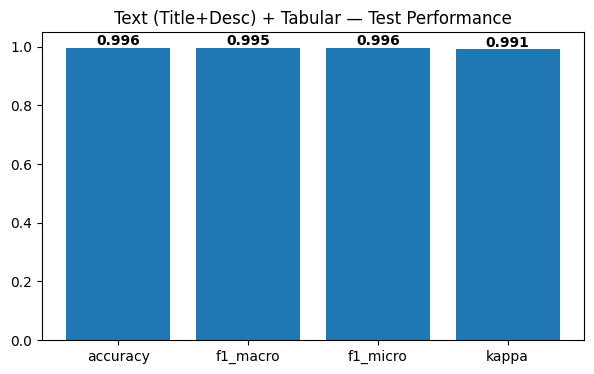

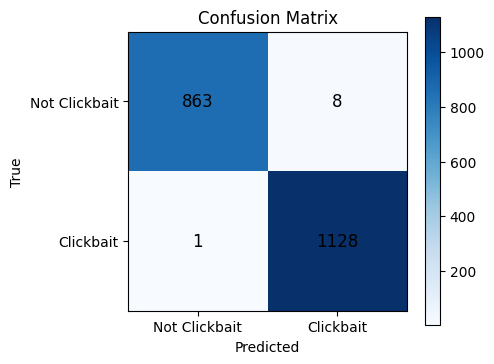

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) metrics bar plot
metric_names = ["accuracy","f1_macro","f1_micro","kappa"]
vals = [metrics[m] for m in metric_names]

plt.figure(figsize=(7,4))
plt.bar(metric_names, vals)
plt.ylim(0, 1.05)
for i,v in enumerate(vals):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center", fontweight="bold")
plt.title("Text (Title+Desc) + Tabular — Test Performance")
plt.show()

# 2) confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(4.5,4))
plt.imshow(cm, cmap="Blues")
plt.xticks([0,1], ["Not Clickbait","Clickbait"])
plt.yticks([0,1], ["Not Clickbait","Clickbait"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()